# Imp Imports

In [1]:
!pip3 install pyyaml

In [2]:
import torch
import torch.nn as nn
import numpy as np

from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cmr10'
plt.rcParams['font.sans-serif'] = 'cmss10'
plt.rcParams['font.monospace'] = 'cmtt10'
plt.rcParams['axes.formatter.use_mathtext'] = True


# Step A: Sparse Linear Layer

In [3]:

class SparseLinear(nn.Module):
    def __init__(self, in_features, out_features, sparsity=0.9):
        super().__init__()
        self.W = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.mask = nn.Parameter(torch.randn(out_features, in_features))
        self.sparsity = sparsity

    def forward(self, x):
        # Hard threshold mask
        k = int(self.sparsity * self.mask.numel())
        threshold = torch.topk(self.mask.flatten(), k, largest=False).values.max()
        M = (self.mask > threshold).float()

        W_sparse = self.W * M
        return x @ W_sparse.T


# Step B: Sparse MLP

In [4]:
class SparseMLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, sparsity=0.9):
        super().__init__()
        self.fc1 = SparseLinear(d_in, d_hidden, sparsity)
        self.fc2 = SparseLinear(d_hidden, d_out, sparsity)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


# Step C: Training Loop

In [5]:
d_in =10; d_hidden = 64; d_out = 1;

In [6]:
#model = SparseMLP(10, 64, 1, sparsity=0.9)
model = SparseMLP(d_in, d_hidden, d_out, sparsity=0.75)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []

for step in range(501):
    x = torch.randn(128*2, 10)
    y = torch.sum(x, dim=1, keepdim=True)

    y_pred = model(x)
    loss = ((y_pred - y)**2).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    loss_history.append(loss.item())

    #if step % 10 == 0:
    #    print("loss:", loss.item())


In [7]:
y_pred = y_pred.detach().numpy()


In [8]:
pred_err = abs(y-y_pred)

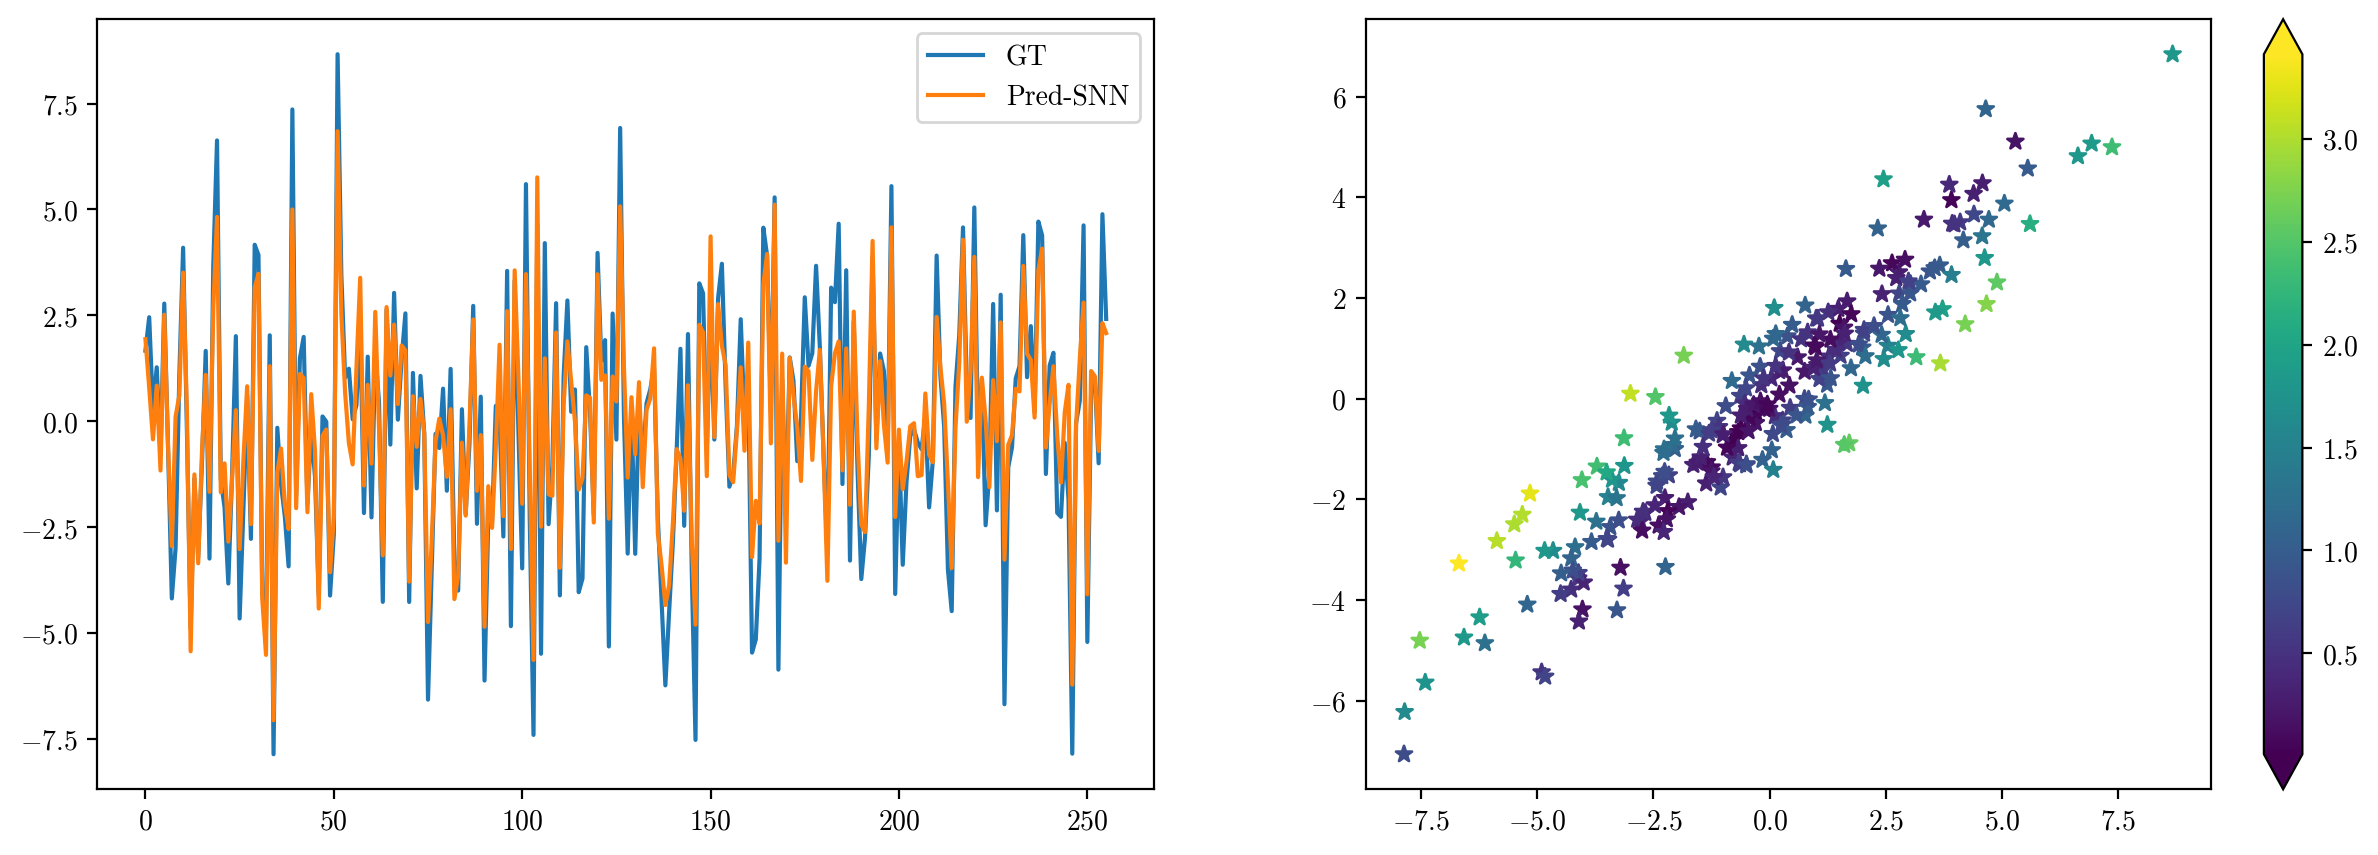

In [9]:
plt.figure(figsize=[15,5],dpi=200)
plt.subplot(121)
plt.plot(y,label='GT')
plt.plot(y_pred,label='Pred-SNN')
plt.legend()
plt.subplot(122)
plt.scatter(y,y_pred,c=pred_err,marker='*')
plt.colorbar(extend='both')
plt.show()

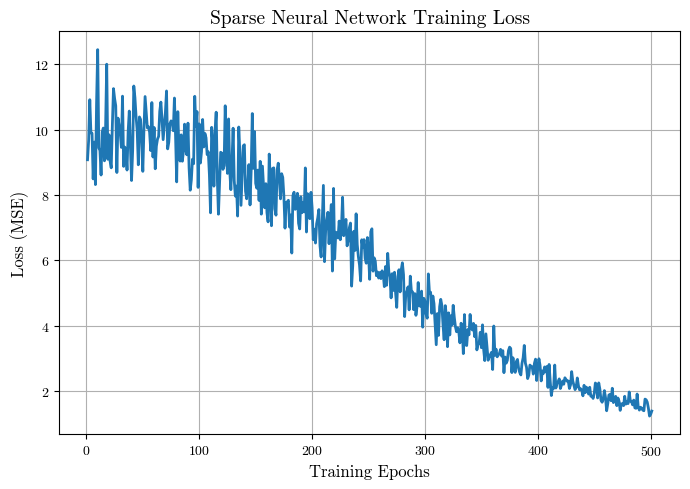

In [10]:
epochs = np.arange(1, len(loss_history) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, loss_history, linewidth=2)
plt.xlabel("Training Epochs", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.title("Sparse Neural Network Training Loss", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

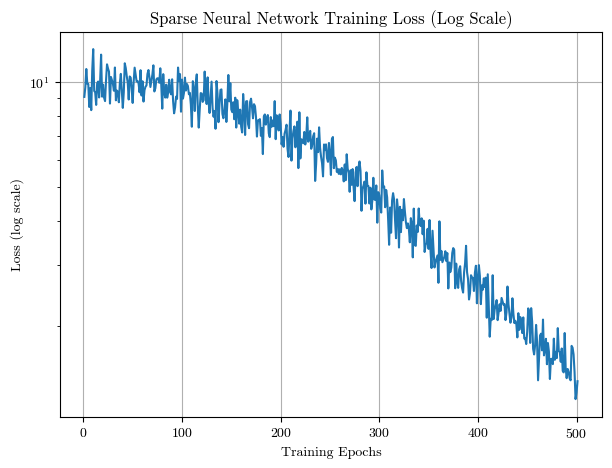

In [11]:
plt.figure(figsize=(7,5))
plt.plot(epochs, loss_history)
plt.yscale("log")
plt.xlabel("Training Epochs")
plt.ylabel("Loss (log scale)")
plt.title("Sparse Neural Network Training Loss (Log Scale)")
plt.grid(True)
plt.show()


# Step D: Count Sparsity

In [12]:
def sparsity_ratio(model):
    total = 0
    nonzero = 0
    for m in model.modules():
        if isinstance(m, SparseLinear):
            W = m.W.detach()
            total += W.numel()
            nonzero += (W != 0).sum().item()
    return 1 - nonzero / total

print("Sparsity:", sparsity_ratio(model))


Sparsity: 0.0


In [13]:
class SparseLinear(nn.Module):
    def __init__(self, in_features, out_features, sparsity=0.9):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.mask_scores = nn.Parameter(torch.randn(out_features, in_features))
        self.sparsity = sparsity  # fraction of zeros

    def get_mask(self):
        # keep (1 - sparsity) fraction of connections
        keep_frac = 1.0 - float(self.sparsity)
        k = max(1, int(keep_frac * self.mask_scores.numel()))

        # threshold = kth largest score
        flat = self.mask_scores.flatten()
        thresh = torch.topk(flat, k, largest=True).values.min()
        M = (self.mask_scores >= thresh).float()
        return M

    def forward(self, x):
        M = self.get_mask()
        W_sparse = self.weight * M
        return x @ W_sparse.T


In [14]:
layer = model.fc1

W = layer.W.detach()
scores = layer.mask.detach()

# build mask as in forward()
k_drop = int(layer.sparsity * scores.numel())
threshold = torch.topk(scores.flatten(), k_drop, largest=False).values.max()
M = (scores > threshold).float()

W_sparse = (W * M).cpu().numpy()

#print("Sparse weights:\n", W_sparse)
print("Active %:", float(M.mean()) * 100)


Active %: 25.0


In [15]:
nonzero = (torch.tensor(W_sparse) != 0).sum().item()
total = W_sparse.size
print(f"Nonzero weights: {nonzero}/{total} ({100*nonzero/total:.2f}%)")


Nonzero weights: 160/640 (25.00%)


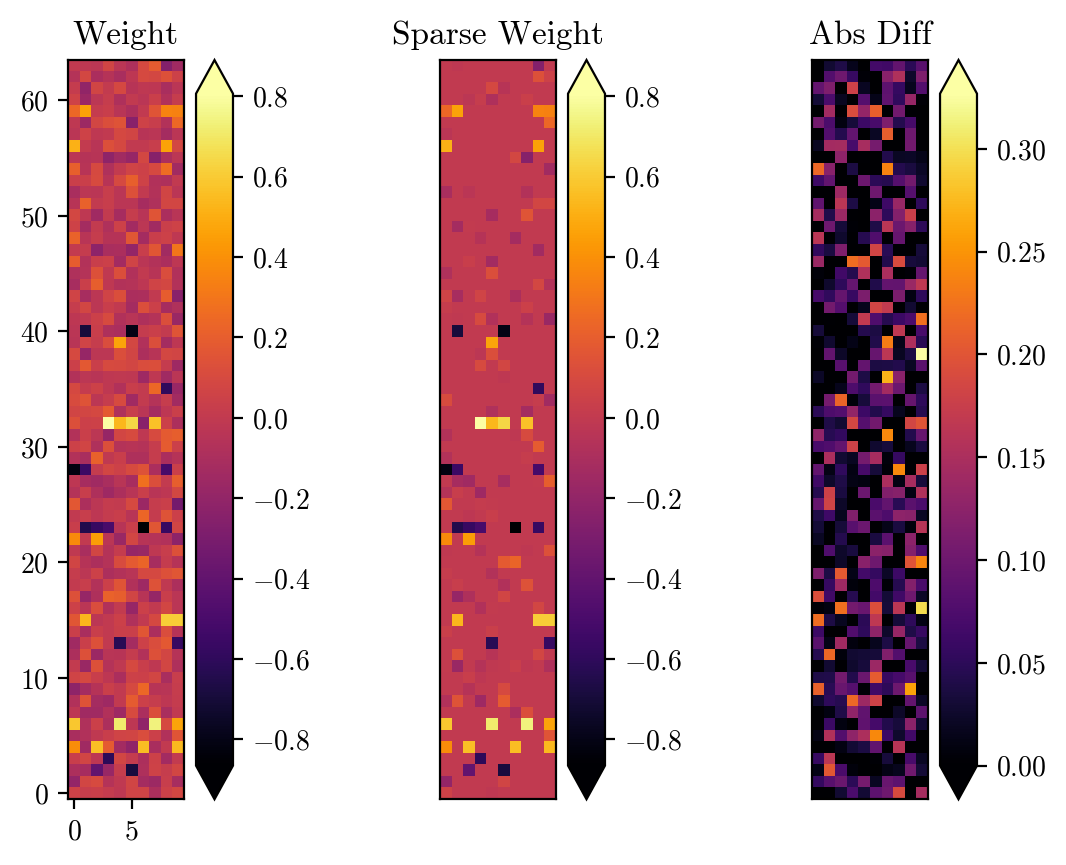

In [16]:
interpolation = 'None'; origin = 'lower'; cmap = plt.cm.inferno; extend = 'both'
plt.figure(dpi=200)
plt.subplot(131)
plt.imshow(W,interpolation=interpolation,origin=origin,cmap=cmap)
plt.title('Weight')
plt.colorbar(extend = extend)
plt.subplot(132)
plt.imshow(W_sparse,interpolation=interpolation,origin=origin,cmap=cmap)
plt.title('Sparse Weight'); plt.xticks([]); plt.yticks([])
plt.colorbar(extend = extend)
plt.subplot(133)
plt.imshow(abs(W-W_sparse),interpolation=interpolation,cmap=cmap)
plt.title('Abs Diff')
plt.xticks([]); plt.yticks([])
plt.colorbar(extend = extend)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()